In [1]:
import numpy as np
import math

In [2]:
#RGC matrices
on_parasol_responses = np.zeros((32,32))
#on_parasol_positions = np.zeros((2*28,16,2))


#Bipolar matrices
on_parasol_bipolar_responses = np.zeros((256,256))
#on_parasol_bipolar_positions = np.zeros((2*256,128,2)) #256 cols in a hex grid means 256 staggered cols = 128 straight cols


#Cone matrices 512x512 area with 2 micron pitch, same spacing as bipolars, for now we'll place all 3 cones
#in the same spot since they all feed directly into each bipolar
cone_responses = np.zeros((256,256))
#L_cone_positions = np.zeros((2*256,128,2)) #256 cols in a hex grid means 256 staggered cols = 128 straight cols

In [3]:
# get cone responses from image

# random data:

cone_responses = np.random.rand(256,256) * 0.0001 #lets assume up to response of 0.0001 for now
cone_responses

array([[3.25997649e-05, 7.69014983e-05, 1.39112588e-05, ...,
        9.77409684e-05, 1.45507561e-06, 3.55881642e-05],
       [1.61972536e-05, 4.17910831e-06, 5.18562622e-05, ...,
        6.42064036e-05, 4.95178039e-05, 1.21466324e-05],
       [1.45091134e-05, 2.85134642e-05, 1.67444811e-05, ...,
        3.26888849e-05, 2.11754463e-05, 4.63074170e-05],
       ...,
       [1.27826814e-05, 8.83093381e-05, 8.23157845e-05, ...,
        2.68787783e-05, 1.72809421e-05, 1.58729879e-05],
       [4.40677981e-05, 6.86734016e-05, 6.64776749e-05, ...,
        6.32642804e-05, 7.04064501e-05, 7.26822442e-05],
       [7.94499896e-05, 9.95548934e-05, 5.27616434e-06, ...,
        1.05225756e-05, 2.60436508e-05, 3.72686760e-05]])

In [4]:
# get bipolar responses from cone outputs


#ignore this, more complicated way of doing this -----------------------------------------------
# intermediate matrix (scale up to get connections around bipolar, then scale down by someing over a region)

# scaled_up_cones = np.zeros((2816,2816))
#scaled_up_radii = np.zeros((2816,2816))
#scaled_up_responses = np.zeros((2816,2816))

#-----------------------------------------------------------------------------------------------

# scale up by 11 (10 microns each axis = 5 neurons each way, this means we have 11x11 cones feeding into each bipolar
# including the cone directly on top of the bipolar)

def DoG_on_parasol_bipolars(r, amp):
    a_cent = 1
    a_sur = 0.01
    sig_cent = 4
    sig_sur = sig_cent * 9
    DoG = a_cent * math.e**(-(r**2)/(2*sig_cent**2)) - a_sur * math.e**(-(r**2)/(2*sig_sur**2))
    return DoG*amp

i=0
j=0
while(i<np.shape(on_parasol_bipolar_responses)[0]):
    while(j<np.shape(on_parasol_bipolar_responses)[1]):
        
        a_init = 0
        b_init = 0
        a_max = 11
        b_max = 11
        
        if(j<5):
            b_init=5-j #only can go over to 0th col of cones
        if(i<5):
            a_init=5-i #only can go over to 0th row of cones
        if(j>250):
            b_max=6+(255-j) #only can go over to 255th col of cones
        if(i>250):
            a_max=6+(255-i) #only can go over to 255th row of cones
        
        a=a_init
        b=b_init
        while(a < a_max):
            while(b < b_max):
                #scaled_up_radii[i*11+a, j*11+b] = math.sqrt(((a-5)**2) + ((b-5)**2))
                
                #scale up and get radii:
                r = math.sqrt(((a-5)**2) + ((b-5)**2))
                
                #get scaled up response:
                in_resp = cone_responses[i+(a-5),j+(b-5)]
                #scaled_up_responses[i*11+a, j*11+b] = DoG_on_parasol_bipolars(r, in_resp)
                resp = DoG_on_parasol_bipolars(r, in_resp)
                
                #scale back down by summing:
                #on_parasol_bipolar_responses[i,j] += scaled_up_responses[i*11+a, j*11+b]
                on_parasol_bipolar_responses[i,j] += resp
                
                b+=1
            b=b_init
            a+=1
        
        j+=1
    j=0
    i+=1


In [5]:

#temporal response


#Since golden paper didn't give any information on the temporal filter (and we are using slightly different
#temporal modeling with single frame of picture shown then nothing for the rest of the 0.4 s), we will use
#exponential decay to model the temporal behavior with the initial value starting at the spacial response
#and the decay value to be 50 (0.02s half life of neuron response strength, close to curve of golden
#temporal response)

#response = init_response * e^(decay_val*t)

decay_val = -50


#on parasol temporal:

initial_on_parasol_bipolar_responses = np.copy(on_parasol_bipolar_responses)

t=0.001 #time steps of 0.001s (400 time periods)
while t<0.4: #simulate 0.4s like golden paper did
    i=0
    j=0
    while(i<np.shape(on_parasol_bipolar_responses)[0]):
        while(j<np.shape(on_parasol_bipolar_responses)[1]):
            #calculate current time's temporal response value with exponential decay equation, then add it
            #to the overall bipolar response
            
            init_response = initial_on_parasol_bipolar_responses[i,j]
            
            response = init_response * math.e**(decay_val*t)
            
            on_parasol_bipolar_responses[i,j] += response #sum over temporal response for each neuron
            
            j+=1
        i+=1
    
    t+=0.001


In [6]:
# get rgc responses from bipolars



# scale up by 32 from rgc matrix (need 25 microns/axis ~12 neurons each way, means we have 25x25 bipolars feeding each
# rgc including the bipolar directly on top of the rgc)
# we need our scaling factor to be a multiple of 4 though (which ignores symmetry), so we will scale by 32x32
# so that despite assymetry, the value we are losing are essentially 0

def DoG_on_parasol(r, amp):
    a_cent = 1
    a_sur = 0.375
    sig_cent = 10
    sig_sur = sig_cent * 1.15
    DoG = a_cent * math.e**(-(r**2)/(2*sig_cent**2)) - a_sur * math.e**(-(r**2)/(2*sig_sur**2))
    return DoG*amp

i=0
j=0
while(i<np.shape(on_parasol_responses)[0]):
    while(j<np.shape(on_parasol_responses)[1]):
        
        a_init = 0
        b_init = 0
        a_max = 32
        b_max = 32
        
        if(j*4<16):
            b_init=16-j*4 #only can go over to 0th col of bipolars
        if(i*4<16):
            a_init=16-i*4 #only can go over to 0th row of bipolars
        if(j*4>239):
            b_max=16+(255-j*4) #only can go over to 255th col of bipolars
        if(i*4>239):
            a_max=16+(255-i*4) #only can go over to 255th row of bipolars
        
        a=a_init
        b=b_init
        while(a < a_max):
            while(b < b_max):
                
                #scale up and get radii:
                r = math.sqrt(((a-16)**2) + ((b-16)**2))
                
                #get scaled up response:
                in_resp = on_parasol_bipolar_responses[i*4+(a-16),j*4+(b-16)]
                resp = DoG_on_parasol(r, in_resp)
                
                #scale baack down by summing:
                on_parasol_responses[i,j] += resp
                
                b+=1
            b=b_init
            a+=1
        
        j+=1
    j=0
    i+=1


In [7]:
on_parasol_responses

array([[0.42868768, 0.59404242, 0.73666874, ..., 0.97117174, 0.98630616,
        0.99846976],
       [0.48775979, 0.67500045, 0.83633207, ..., 1.11356598, 1.12879331,
        1.14012849],
       [0.50404068, 0.69777873, 0.86473928, ..., 1.15981148, 1.17342159,
        1.18253874],
       ...,
       [0.45867358, 0.64361889, 0.79933526, ..., 0.94914099, 0.94963153,
        0.95353075],
       [0.45350856, 0.63735986, 0.7921285 , ..., 0.94443064, 0.9476079 ,
        0.95535144],
       [0.45088158, 0.63418908, 0.78854426, ..., 0.9417008 , 0.94791407,
        0.95968579]])

In [8]:
#convert response to firing rate


#go through all rgc responses and convert response to firing rate

#-----------------------------------------------------------------------------------------------
#important: adjust the exponential function later once voltages are adjusted

#we'll use an exponential function to get spike rate from rgc response (golden got this from pillow et al 2008)
#large rgc response is 1.1, so exponential goes from e^0=1 to e^1.2=3.00
#6 Hz seems to be a large neuron firing rate for an RGC (from other studies), so we'll use this as max_rate
#exponential function: firing_rate = max_rate*((e^(response)-1)/2.00)
#subtract 1 from exponential so we have values starting from 0 to 2.00, divide by 2.00 and multiply by max rate so
#large responses will be about equal to our inputted max firing rate (maybe slightly larger)

max_rate = 6 #6Hz seems to be a very large RGC firing rate

#hopefully the learned reconstruction matrix will be able to compensate for any differences we've made in
#our equations (as long as we use the same equations here and in learning)


#on parasol rgcs:

i=0
j=0
while(i<np.shape(on_parasol_responses)[0]):
    while(j<np.shape(on_parasol_responses)[1]):
        response = on_parasol_responses[i,j]
        
        firing_rate = max_rate*((math.e**(response)-1)/2)
        
        if(firing_rate < 0):
            firing_rate = 0
        
        on_parasol_responses[i,j] = firing_rate
        
        j+=1
    j=0
    i+=1



In [9]:
on_parasol_responses

array([[1.60572444, 2.43388699, 3.26689506, ..., 4.92311174, 5.04393544,
        5.14237614],
       [1.88599073, 2.89210161, 3.92365879, ..., 6.13559452, 6.2757698 ,
        6.38151048],
       [1.96619009, 3.02785376, 4.12316085, ..., 6.56799586, 6.69910762,
        6.78794014],
       ...,
       [1.74592271, 2.7100694 , 3.67218601, ..., 4.75046839, 4.75427123,
        4.78456588],
       [1.72147309, 2.6744415 , 3.62427402, ..., 4.71404684, 4.73859535,
        4.79875208],
       [1.70908615, 2.65647764, 3.60057359, ..., 4.69301742, 4.74096498,
        4.83262791]])

In [7]:
# get downloaded images from imagenet

import cv2
path = 'C:/Users/rhyst/Downloads/'
name = 'test_image.png'
image = cv2.imread(path+name, cv2.IMREAD_GRAYSCALE)

(256, 256)


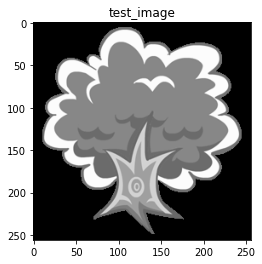

In [8]:
from matplotlib import pyplot as plt
plt.imshow(image, cmap='gray')
plt.title('test_image')
plt.show()

In [ ]:
# largest grayscale value is 255, we want the largest value to be at most 0.0001,
# set cone_responses to be image*(0.0001/255)